In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels
import statsmodels.api as sm

import os

import tensorflow as tf
from tensorflow import keras

import math
import keras

from sklearn.metrics import mean_squared_error

from datetime import datetime, timedelta
import urllib

import seaborn as sns

# Whole DATA

## Get data from URL -> make timeseries

### All the data:

In [8]:
def get_weather_data(start_year, start_month, start_day, end_year, end_month, end_day):
    url = f'https://meteo.physic.ut.ee/et/archive.php?do=data&begin%5Byear%5D={start_year}&begin%5Bmon%5D={start_month}&begin%5Bmday%5D={start_day}&end%5Byear%5D={end_year}&end%5Bmon%5D={end_month}&end%5Bmday%5D={end_day}&9=1&12=1&10=1&15=1&16=1&14=1&ok=+Esita+p%C3%A4ring+'
    file = urllib. request. urlopen(url)
    lines = []
    for line in file:
        decoded_line = line.decode("utf-8")
        new_line = decoded_line.replace(" ","").strip()
        lines.append(new_line)
    with open('data.csv', 'w') as f:
        f.write('\n'.join(lines))
    data = pd.read_csv('data.csv')
    data.columns = ['timestamp', 'temperature', 'humidity', 'atm_pressure', 'windspeed', 'wind_direction', 'precipitation', 'radiation_flux']
    return data

In [18]:
data2021 = get_weather_data(2021,1,1,2021,11,30)

In [19]:
data2020 = get_weather_data(2020,1,1,2020,12,31)

In [20]:
data2019 = get_weather_data(2019,1,1,2019,12,31)

In [25]:
data = data2021.append(data2020.append(data2019))

In [27]:
data.shape

(308529, 8)

In [12]:
def break_up_time(data):
    data["year"]= data.apply(lambda row: row["timestamp"][0:4], axis=1)
    data["month"] = data.apply(lambda row: row["timestamp"][5:7], axis=1)
    data["day"] = data.apply(lambda row: row["timestamp"][8:10], axis=1)
    data["hour"] = data.apply(lambda row: row["timestamp"][10:12], axis=1)
    data["minute"] = data.apply(lambda row: row["timestamp"][13:15], axis=1)
    data.year = data.year.astype('int')
    data.month = data.month.astype('int')
    data.day = data.day.astype('int')
    data.hour = data.hour.astype('int')
    data.minute = data.minute.astype('int')
    data["timestamp"] = data.apply(lambda row: datetime.strptime(row["timestamp"],"%Y-%m-%d%H:%M:%S"), axis=1)
    return data

def fill_and_correct(data):
    # if there is no rain and no snow:
    #data['snow'] = data['snow'].fillna(0)
    data['precipitation'] = data['precipitation'].fillna(0)
    # for other 
    data['windspeed'] = data['windspeed'].fillna(method='backfill')
    data['wind_direction'] = data['wind_direction'].fillna(method='backfill')
    data['temperature'] = data['temperature'].fillna(method='backfill')
    data['humidity'] = data['humidity'].fillna(method='backfill')
    data['atm_pressure'] = data['atm_pressure'].fillna(method='backfill')
    data['radiation_flux'] = data['radiation_flux'].fillna(method='backfill')
    data = data.dropna()
    return data

def cleansing(data):
    data = break_up_time(data)
    data = fill_and_correct(data)
    return data

In [28]:
data = cleansing(data)

### Make time series:

In [13]:
def parser(x):
    return datetime.strptime(x,"%Y-%m-%d %H:%M:%S")

def to_timeseries(series):
    series.to_csv("series_rad.csv",index=False)
    series = pd.read_csv("series_rad.csv",header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
    series.index = series.index.to_period('T')
    return series

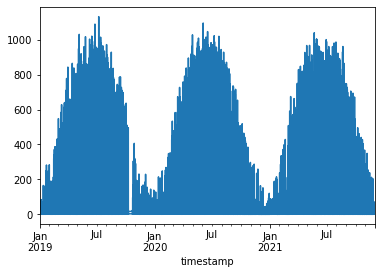

In [31]:
radiation = to_timeseries(data[["timestamp","radiation_flux"]])
radiation.plot()
plt.show()

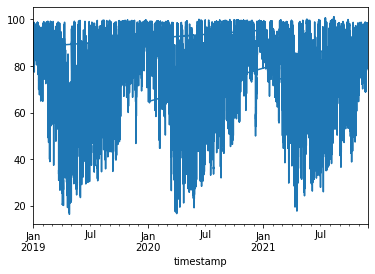

In [33]:
humidity = to_timeseries(data[["timestamp","humidity"]])
humidity.plot()
plt.show()

### Filter shorter periods

In [87]:
radiation2021 = radiation.loc['2021-01-01 00:00':]

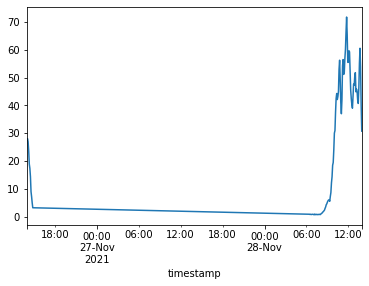

In [102]:
radiation.loc['2021-11-26 14:00':'2021-11-28 13:55'].plot()
plt.show()

In [44]:
data_test = get_weather_data(2021,12,1,2021,12,9)
data_test = cleansing(data_test)
radiation_test = to_timeseries(data_test[["timestamp","radiation_flux"]])

# ARIMA

## About

An ARIMA model is a class of statistical models for analyzing and forecasting time series data.

It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.
d: The number of times that the raw observations are differenced, also called the degree of differencing.
q: The size of the moving average window, also called the order of moving average.
A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

Adopting an ARIMA model for a time series assumes that the underlying process that generated the observations is an ARIMA process. This may seem obvious, but helps to motivate the need to confirm the assumptions of the model in the raw observations and in the residual errors of forecasts from the model.

## Autocorrelation

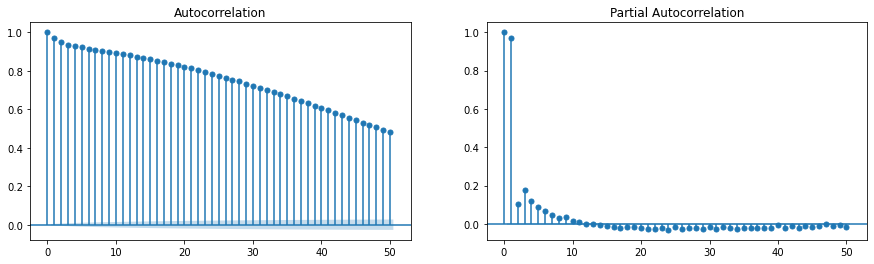

In [38]:
fig, axes = plt.subplots(1,2,figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(radiation2021,lags=50,ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(radiation2021,lags=50,ax=axes[1])


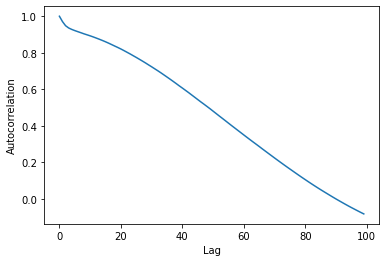

In [41]:
AC = []
for l in range(100): AC.append(radiation2021.autocorr(lag=l))
plt.plot(range(100),AC)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

## Train and predict

In [111]:
ct = datetime.now()
t1 = str(ct - timedelta(days=8))[:15]+"0"
t2 = str(ct - timedelta(days=1))[:15]+"0"
t1,t2


('2021-12-03 14:10', '2021-12-10 14:10')

In [114]:
model = ARIMA(radiation2021, order=(1,0,1))
model_fit = model.fit() 
print(model_fit.summary())

/Users/heidi/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/Users/heidi/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/Users/heidi/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'


                               SARIMAX Results                                
Dep. Variable:         radiation_flux   No. Observations:               308529
Model:                 ARIMA(1, 0, 1)   Log Likelihood            -1631046.625
Date:                Sat, 11 Dec 2021   AIC                        3262101.251
Time:                        14:16:16   BIC                        3262143.809
Sample:                             0   HQIC                       3262113.545
                             - 308529                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        117.8804      8.932     13.197      0.000     100.374     135.387
ar.L1          0.9806      0.000   2255.859      0.000       0.980       0.981
ma.L1         -0.1825      0.001   -343.149      0.0

In [153]:
pred_rad = model_fit.predict()[144:168]
len(pred_rad)

24

In [154]:
test_rad = radiation_test[144:168]

In [155]:
rmse = np.sqrt(mean_squared_error(test_rad, pred_rad))
rmse

9.580378210087497

In [156]:
test_rad.head(10)

timestamp
2021-12-01 12:00    46.287075
2021-12-01 12:05    42.787431
2021-12-01 12:10    41.967988
2021-12-01 12:15    49.663946
2021-12-01 12:20    46.368431
2021-12-01 12:25    50.179031
2021-12-01 12:30    45.781214
2021-12-01 12:35    42.480555
2021-12-01 12:40    43.788025
2021-12-01 12:45    40.927642
Freq: T, Name: radiation_flux, dtype: float64

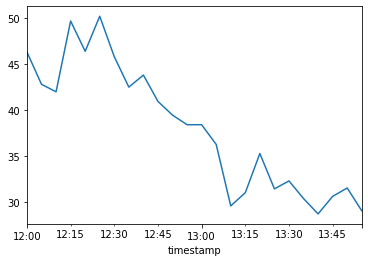

In [157]:
test_rad.plot()
plt.show()

## Evaluate an ARIMA model using a walk-forward validation

values X:  (97712,) <class 'numpy.ndarray'>
train:  (97424,) <class 'numpy.ndarray'>
test:  (288,) <class 'numpy.ndarray'>
history:  97424 <class 'list'>


/Users/heidi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                97424
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -518234.469
Date:                Thu, 09 Dec 2021   AIC                        1036474.939
Time:                        23:53:11   BIC                        1036503.399
Sample:                             0   HQIC                       1036483.586
                              - 97424                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5624      0.002    270.777      0.000       0.558       0.566
ma.L1         -0.8059      0.002   -444.282      0.000      -0.809      -0.802
sigma2      2443.0754      2.999    814.728      0.0

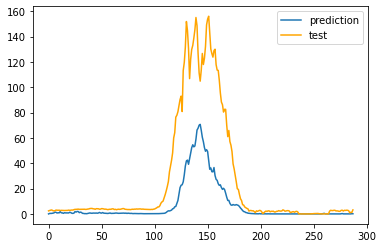

In [82]:
# split into train and test sets
X = data.values
size = int(len(X)-288) # test for last 288 intervals (24h) as we want to predict the same period
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
# print set sizes and types
print("values X: ",X.shape,type(X))
print("train: ",train.shape,type(train))
print("test: ",test.shape,type(test))
print("history: ",len(history),type(history))
# hyperparameters
p, d, q = 1, 1, 1
# fit model
model = ARIMA(history, order=(p,d,q))
model_fit = model.fit() 
print(model_fit.summary())
# predict
output = model_fit.predict()
pred_radiation = output[:288]
# evaluate
rmse = np.sqrt(mean_squared_error(test, pred_radiation))
print('Test RMSE: %.3f' % rmse)
# plot test and predictions
plt.plot(pred_radiation,label="prediction")
plt.plot(test, color="orange",label="test")
plt.legend()
plt.show()

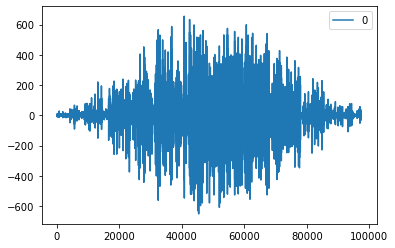

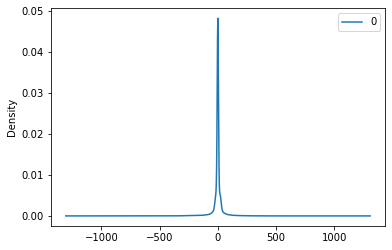

                  0
count  97424.000000
mean       0.000051
std       49.426496
min     -652.301197
25%       -1.848223
50%       -0.000033
75%        1.782339
max      654.797391


In [81]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

Don't try this -> :D

In [83]:
for p in range(1,30):
    for d in range(2):
        for q in range(1):
            # hyperparameters
            print(p,d,q)
            # fit model
            model = ARIMA(history, order=(p,d,q))
            model_fit = model.fit() 
            # predict
            output = model_fit.predict()
            pred_radiation = output[:288]
            # evaluate
            rmse = np.sqrt(mean_squared_error(test, pred_radiation))
            print('Test RMSE: %.3f' % rmse)

1 0 0
Test RMSE: 34.204
1 1 0
Test RMSE: 34.862
2 0 0
Test RMSE: 34.317
2 1 0
Test RMSE: 34.862
3 0 0
Test RMSE: 34.508
3 1 0
Test RMSE: 34.861
4 0 0
Test RMSE: 34.644
4 1 0
Test RMSE: 34.857
5 0 0
Test RMSE: 34.729
5 1 0
Test RMSE: 34.854
6 0 0
Test RMSE: 34.777
6 1 0
Test RMSE: 34.853
7 0 0
Test RMSE: 34.822
7 1 0
Test RMSE: 34.853
8 0 0
Test RMSE: 34.838
8 1 0
Test RMSE: 34.854
9 0 0
Test RMSE: 34.862
9 1 0
Test RMSE: 34.855
10 0 0
Test RMSE: 34.873
10 1 0
Test RMSE: 34.856
11 0 0
Test RMSE: 34.875
11 1 0
Test RMSE: 34.857
12 0 0
Test RMSE: 34.878
12 1 0
Test RMSE: 34.858
13 0 0
Test RMSE: 34.876
13 1 0
Test RMSE: 34.857
14 0 0
Test RMSE: 34.870
14 1 0
Test RMSE: 34.853
15 0 0
Test RMSE: 34.854
15 1 0
Test RMSE: 34.851
16 0 0
Test RMSE: 34.846
16 1 0
Test RMSE: 34.848
17 0 0
Test RMSE: 34.832
17 1 0
Test RMSE: 34.838
18 0 0
Test RMSE: 34.804
18 1 0
Test RMSE: 34.836
19 0 0
Test RMSE: 34.793
19 1 0
Test RMSE: 34.829
20 0 0
Test RMSE: 34.772
20 1 0


KeyboardInterrupt: 